In [42]:
#Importing libraries and modules 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os


In [67]:
# Path definitions
train_path = '/kaggle/input/gtsrb-german-traffic-sign/'  # Using test images for training
test_csv_path = '/kaggle/input/gtsrb-german-traffic-sign/Test.csv'
test_images_path = '/kaggle/input/gtsrb-german-traffic-sign/'
train_path1 = '/kaggle/input/gtsrb-german-traffic-sign/Test'

# Class names and number of classes
class_names = os.listdir(train_path1)
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")


Number of classes: 12631


In [68]:
# Data augmentation and transformation
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [69]:
# Custom TestDataset class with corrected path handling and error skipping
class TestDataset(Dataset):
    def __init__(self, csv_path, root_dir, transform=None):
        self.data = pd.read_csv(csv_path)
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.data.iloc[idx, 7])  # Assuming column 7 has image file names
        label = self.data.iloc[idx, 6]  # Assuming column 6 has labels
        
        try:  #This handles the paths with no img files .
            # Load image
            img = Image.open(img_path).convert('RGB')
            
            # Apply transformations if specified
            if self.transform:
                img = self.transform(img)
            
            return img, label
        
        except Exception as e:
            print(f"Error loading image at index {idx}: {e}")
            return None, None


In [86]:
# Loading the datasets 
train_dataset = TestDataset(test_csv_path, root_dir=train_path, transform=transform)
test_dataset = TestDataset(test_csv_path, root_dir=test_images_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


In [71]:
# Define the CNN model with 3 conv layers ,initializing with 3 kernel(filter size)
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1)
        self.dropout1 = nn.Dropout(0.20)
        self.fc1 = nn.Linear(16 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout2 = nn.Dropout(0.33)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout2(x)
        
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Model, optimizer, and loss function
model = CNN(num_classes)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()


In [72]:
# Training the model
epochs = 3
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")


Epoch 1, Loss: 2.55866938482357
Epoch 2, Loss: 1.0713836397551284
Epoch 3, Loss: 0.5753353158507166


In [73]:
# Model evaluation function
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_labels, all_preds

# Evaluation score
true_labels, predictions = evaluate_model(model, test_loader)


In [85]:
# Evaluating model performance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy_m = accuracy_score(true_labels, predictions) #accuracy score when kernel=3 is 93%
print("The accuracy score for the model is:", accuracy_m)
print(classification_report(true_labels, predictions))
cm = confusion_matrix(true_labels, predictions)
print('Confusion Matrix:')
print(cm)


The accuracy score for the model is: 0.9259699129057799
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        60
           1       0.92      0.93      0.92       720
           2       0.89      0.86      0.88       750
           3       0.90      0.85      0.87       450
           4       0.68      0.95      0.79       660
           5       0.85      0.75      0.79       630
           6       1.00      0.86      0.92       150
           7       0.96      0.77      0.85       450
           8       0.93      0.78      0.85       450
           9       1.00      0.99      1.00       480
          10       0.98      1.00      0.99       660
          11       0.99      0.98      0.98       420
          12       1.00      0.99      0.99       690
          13       0.98      1.00      0.99       720
          14       0.98      1.00      0.99       270
          15       1.00      0.95      0.97       210
          16       0.99  

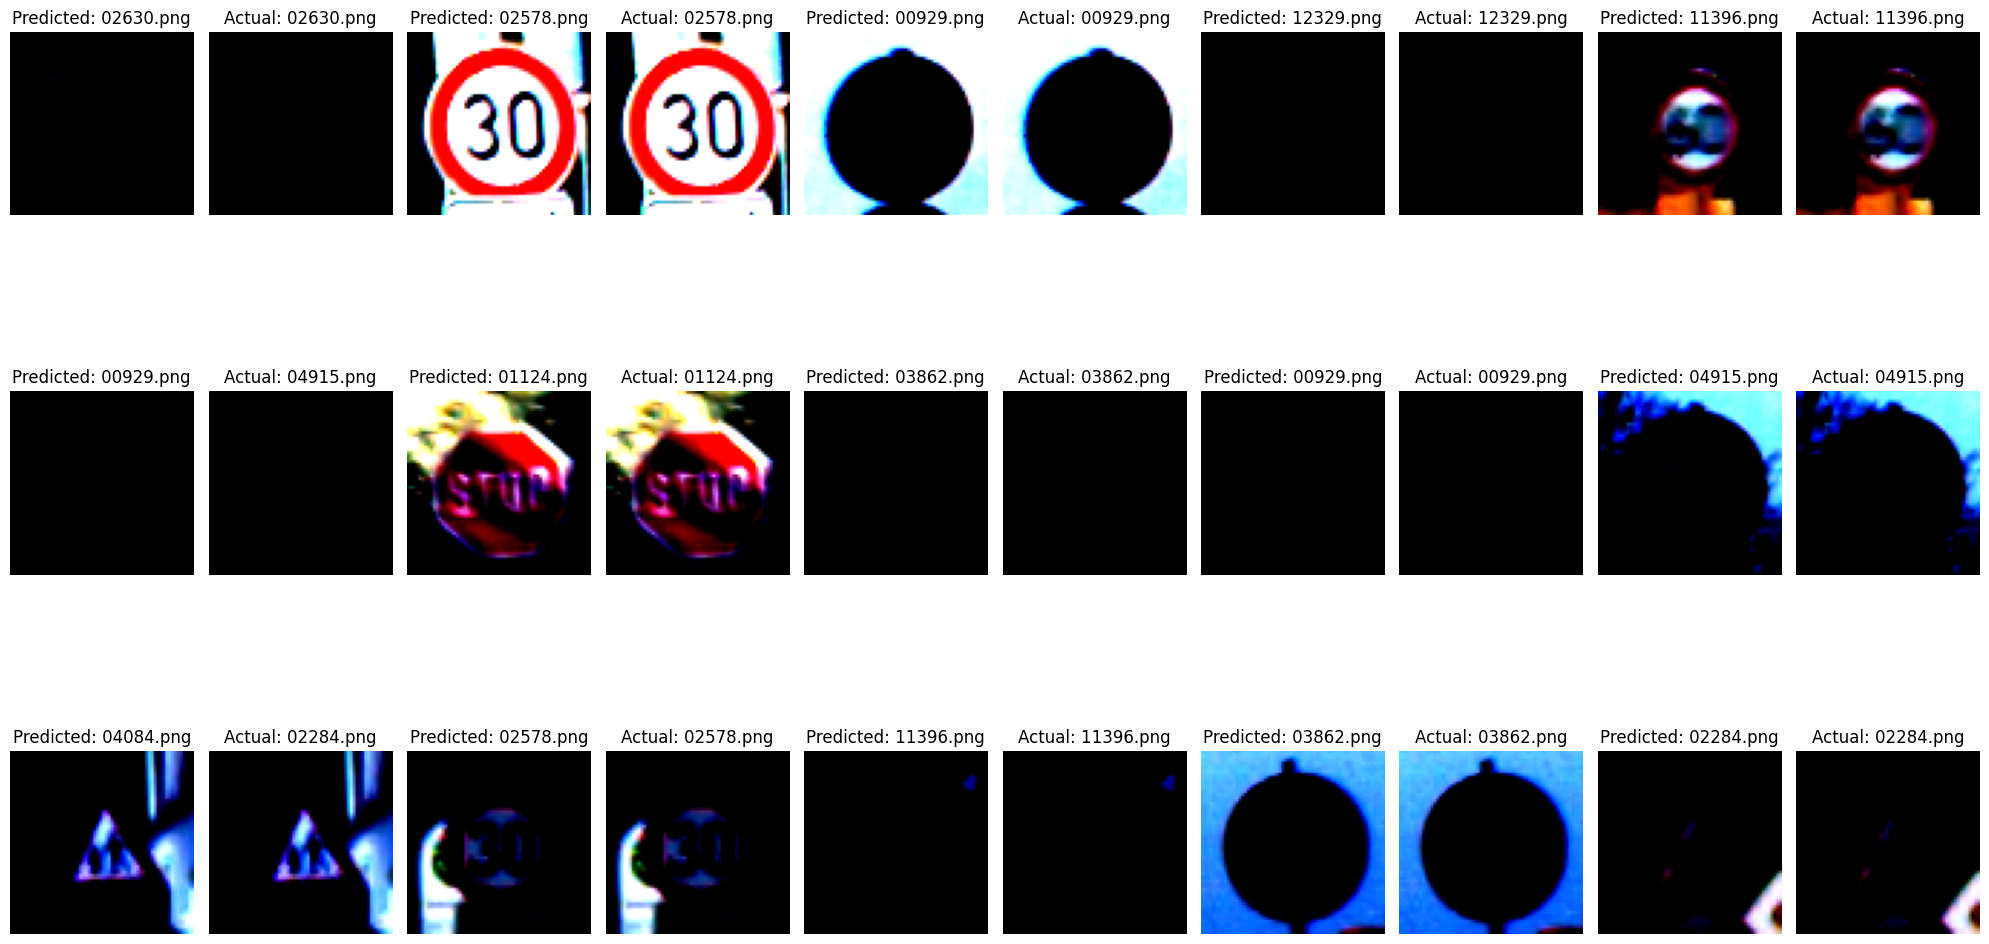

In [81]:

# Define a function to visualize predictions vs actual labels
def visualize_predictions(model, data_loader, class_names):
    model.eval()
    fig, axes = plt.subplots(3, 10, figsize=(20, 12))  # Ensure this matches your intended layout
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loader):
            if i >= 3:  # Show predictions for the first 3 batches
                break
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size(0)):
                try:
                    ax_pred = axes[i, j * 2]  # Ensure j * 2 is within valid range for axes columns
                    ax_actual = axes[i, j * 2 + 1]  # Ensure j * 2 + 1 is within valid range for axes columns
                except IndexError:
                    break  # Skip further plotting if index is out of bounds
                
                ax_pred.imshow(inputs[j].permute(1, 2, 0).cpu().numpy())  # Convert tensor to numpy for visualization
                ax_pred.set_title(f'Predicted: {class_names[preds[j]]}')
                ax_pred.axis('off')
                
                ax_actual.imshow(inputs[j].permute(1, 2, 0).cpu().numpy())  # Convert tensor to numpy for visualization
                ax_actual.set_title(f'Actual: {class_names[labels[j]]}')
                ax_actual.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming model, test_loader, and class_names are defined elsewhere
visualize_predictions(model, test_loader, class_names)


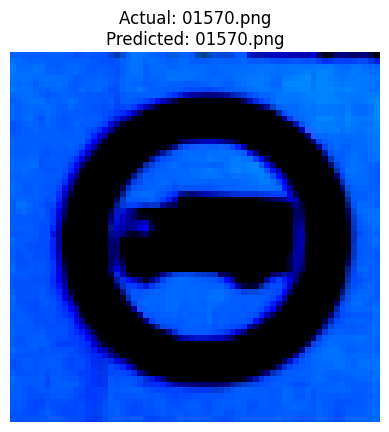

In [83]:
# Choose a random image from the test dataset
index = 0  # Change this index to select a different image
image, label = test_dataset[index]


# Add a batch dimension and move to the same device as model
image = image.unsqueeze(0)

# Make predictions
model.eval()
with torch.no_grad():
    output = model(image)
    _, prediction = torch.max(output, 1)

# Display the image and predicted label
plt.imshow(image.squeeze().permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.title(f'Actual: {class_names[label]}\nPredicted: {class_names[prediction]}')
plt.show()


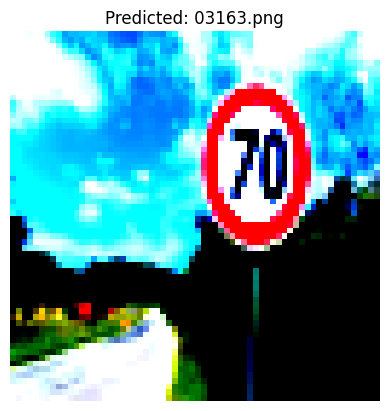

In [84]:
#Picking image from the device and predicted based on that .
image_path = '/kaggle/input/testing-images/testing_img.jfif'  
img = Image.open(image_path)

# Define transformations to match your model's input requirements
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to match your model's input size
    transforms.ToTensor(),        # Convert PIL image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Apply transformations
img = transform(img)

# Add a batch dimension and move to the same device as the model
img = img.unsqueeze(0)  # Add batch dimension

# Make predictions
model.eval()
with torch.no_grad():
    output = model(img)
    _, prediction = torch.max(output, 1)

# Display the image and predicted label
plt.imshow(img.squeeze().permute(1, 2, 0).cpu().numpy())  # Convert tensor back to numpy for visualization
plt.axis('off')
plt.title(f'Predicted: {class_names[prediction.item()]}')
plt.show()